In [1]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif

# Model evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [2]:
# Read data
def read_data(filename):
    base_path = "../Data/process/"
    return pd.read_csv(base_path + filename + '.csv')

In [3]:
X_train = read_data('X_train')
y_train = read_data('y_train')['churn']

# Validation dataset
X_val = read_data('X_validation')
y_val = read_data('y_validation')['churn']

In [55]:
def get_cv_scores(models, X, y, Kfold=10):

    # Create a stratified k-fold object.
    stratified_kfold = StratifiedKFold(n_splits=Kfold, shuffle=True, random_state=42)

    # Perform cross-validation
    score_list = []
    for name, clf in models.items():
        scores = cross_validate(estimator=clf, 
                                X=X, 
                                y=y, 
                                cv=stratified_kfold,
                                scoring=('accuracy', 'f1_macro'),
                                return_train_score=True,
                                n_jobs=-1)

        # Training Scores
        train_accuracy = scores['train_accuracy'].mean()
        train_f1_score, train_std = scores['train_f1_macro'].mean(), scores['train_f1_macro'].std()

        # Test Scores
        test_accuracy = scores['test_accuracy'].mean()
        test_f1_score, test_std = scores['test_f1_macro'].mean(), scores['test_f1_macro'].std()

        score_list.append((name, train_accuracy, test_accuracy, train_f1_score, train_std, test_f1_score, test_std))
        print(f"{name} --> {test_f1_score:.3f} +- {test_std:.3f}")

    
    # Create a score dataframe
    
    names = ['model', 'train_accuracy', 'test_accuracy', 'train_f1_score', 'train_std', 'test_f1_score', 'test_std']
    score_df = pd.DataFrame(score_list, columns=names)
    score_df.set_index('model', inplace=True)
    return score_df.style.highlight_max(['test_f1_score'], color='purple', axis=0)
        

In [23]:
# Model selection of base estimator
models = {
    'LR': LogisticRegression(),
    'Tree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'Kneighbors': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB(),
    'SVC': SVC(random_state=42),
    'XGBoostClf': XGBClassifier(random_state=42)
}

In [ ]:
get_cv_scores(models, X_train, y_train)

In [25]:
# Create a stratified k-fold object.
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
stratified_score_list = []
for name, clf in models.items():
    scores = cross_validate(estimator=clf, 
                            X=X_train, 
                            y=y_train, 
                            cv=stratified_kfold,
                            scoring=('accuracy', 'f1_macro'),
                            return_train_score=True,
                            n_jobs=-1)

    # Training Scores
    train_accuracy = scores['train_accuracy'].mean()
    train_f1_score, train_std = scores['train_f1_macro'].mean(), scores['train_f1_macro'].std()

    # Test Scores
    test_accuracy = scores['test_accuracy'].mean()
    test_f1_score, test_std = scores['test_f1_macro'].mean(), scores['test_f1_macro'].std()

    stratified_score_list.append((name, train_accuracy, test_accuracy, train_f1_score, train_std, test_f1_score, test_std))
    print(f"{name} --> {test_f1_score:.3f} +- {test_std:.3f}")

LR --> 0.634 +- 0.019
Tree --> 0.674 +- 0.019
RandomForest --> 0.725 +- 0.029
Kneighbors --> 0.688 +- 0.020
NaiveBayes --> 0.642 +- 0.148
SVC --> 0.684 +- 0.021
XGBoostClf --> 0.718 +- 0.020


In [26]:
names = ['model', 'train_accuracy', 'test_accuracy', 'train_f1_score', 'train_std', 'test_f1_score', 'test_std']
score_df = pd.DataFrame(stratified_score_list, columns=names)
score_df.set_index('model', inplace=True)

In [27]:
score_df.style.highlight_max(['test_f1_score'], color='red', axis=0)

,train_accuracy,test_accuracy,train_f1_score,train_std,test_f1_score,test_std
model,,,,,,
LR,0.815852,0.814857,0.635044,0.002386,0.633581,0.019210
Tree,1.000000,0.777524,1.000000,0.000000,0.673706,0.019115
RandomForest,0.999958,0.844381,0.999936,0.000191,0.725179,0.028825
Kneighbors,0.867492,0.819619,0.774470,0.004935,0.688135,0.020357
NaiveBayes,0.728190,0.727238,0.643778,0.148499,0.641967,0.148448
SVC,0.851238,0.839048,0.709304,0.003984,0.683612,0.021243
XGBoostClf,0.975810,0.834857,0.962261,0.004069,0.718241,0.020126


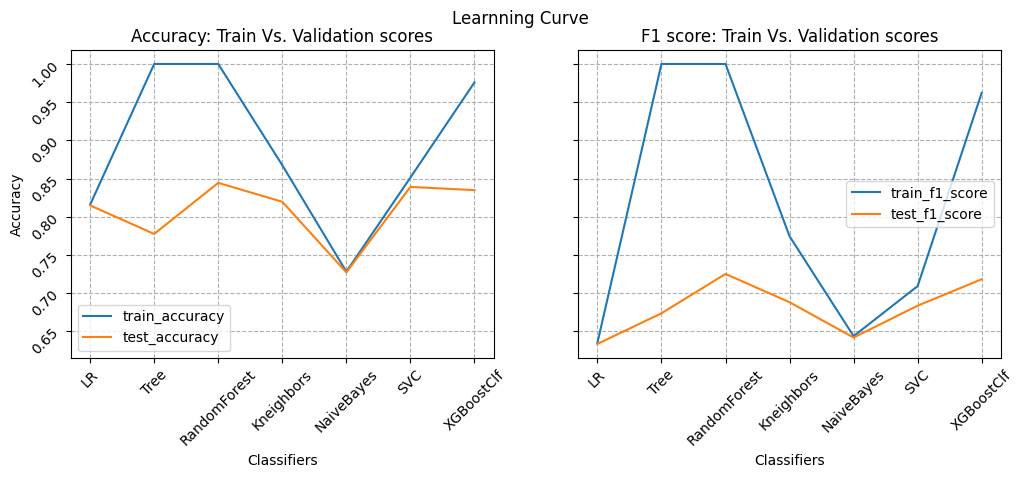

In [29]:
# Learning curve
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)

score_df.iloc[:, [0, 1]].plot(kind='line',
                              ax=ax1,
                              title='Accuracy: Train Vs. Validation scores',
                              xlabel='Classifiers', ylabel='Accuracy')

score_df.iloc[:, [2, 4]].plot(kind='line',
                              ax=ax2,
                              title='F1 score: Train Vs. Validation scores',
                              xlabel='Classifiers', ylabel='Precision_score')

# set grids
ax1.grid(ls='--')
ax2.grid(ls='--')

# Rotate the labels
ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)

fig.suptitle('Learnning Curve', size=12)
plt.show()

- *F1 scores is selected to measure the performace of the model as the data set is imbalanced and we are also looking at the model that produce high precision and recall scores.*
- *Random forest classifier scored high f1-scores. However, overfitting can observed in tree-based classifiers,which gives perfect score on training data.*
- *Let's calculate the mutual information score on features and select the top 10 features and then again observed the cross validation scores.*

In [80]:
# Calculate the mutual information to find top 10 features.
mi_score = mutual_info_classif(X_train, y_train)
top_10_features = pd.Series(mi_score, index=X_train.columns).sort_values(ascending=False)[:10].index.tolist()

In [31]:
X_train[top_10_features]

,num_scaler__num_of_products,cat_oh_en__age_group_48-62,cat_oh_en__age_group_18-32,remainder__is_active_member,cat_oh_en__geography_germany,num_scaler__credit_score,num_scaler__balance,num_scaler__salary,cat_oh_en__geography_france,cat_oh_en__age_group_33-47
0,-0.903049,0.0,1.0,1.0,0.0,0.670220,0.401538,-0.285113,0.0,0.0
1,2.501625,0.0,0.0,0.0,0.0,0.358795,-1.212180,0.950511,0.0,1.0
2,-0.903049,0.0,0.0,1.0,1.0,0.929740,0.990397,-0.863601,0.0,1.0
3,0.799288,0.0,1.0,0.0,0.0,-0.741573,-1.212180,-0.944384,0.0,0.0
4,-0.903049,0.0,0.0,0.0,0.0,-1.956129,1.371400,1.420959,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
5245,-0.903049,1.0,0.0,1.0,1.0,-0.378244,0.655053,0.056637,0.0,0.0
5246,-0.903049,0.0,0.0,0.0,0.0,1.936681,-0.005129,-0.667591,0.0,1.0
5247,2.501625,0.0,0.0,0.0,1.0,0.690981,0.979045,0.833188,0.0,1.0
5248,-0.903049,0.0,0.0,1.0,0.0,0.836313,0.481548,0.008674,0.0,1.0


In [32]:
# Trained a model again with top10 features.

# Create a stratified k-fold object.
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
stratified_score_list = []
for name, clf in models.items():
    scores = cross_validate(estimator=clf, 
                            X=X_train, 
                            y=y_train, 
                            cv=stratified_kfold,
                            scoring=('accuracy', 'f1_macro'),
                            return_train_score=True,
                            n_jobs=-1)

    # Training Scores
    train_accuracy = scores['train_accuracy'].mean()
    train_f1_score, train_std = scores['train_f1_macro'].mean(), scores['train_f1_macro'].std()

    # Test Scores
    test_accuracy = scores['test_accuracy'].mean()
    test_f1_score, test_std = scores['test_f1_macro'].mean(), scores['test_f1_macro'].std()

    stratified_score_list.append((name, train_accuracy, test_accuracy, train_f1_score, train_std, test_f1_score, test_std))
    print(f"{name} --> {test_f1_score:.3f} +- {test_std:.3f}")
    

# Create a score dataframe
names = ['model', 'train_accuracy', 'test_accuracy', 'train_f1_score', 'train_std', 'test_f1_score', 'test_std']
score_df = pd.DataFrame(stratified_score_list, columns=names)
score_df.set_index('model', inplace=True)

score_df.style.highlight_max(['test_f1_score'], color='red', axis=0)

LR --> 0.634 +- 0.019
Tree --> 0.674 +- 0.019
RandomForest --> 0.725 +- 0.029
Kneighbors --> 0.688 +- 0.020
NaiveBayes --> 0.642 +- 0.148
SVC --> 0.684 +- 0.021
XGBoostClf --> 0.718 +- 0.020


,train_accuracy,test_accuracy,train_f1_score,train_std,test_f1_score,test_std
model,,,,,,
LR,0.815852,0.814857,0.635044,0.002386,0.633581,0.019210
Tree,1.000000,0.777524,1.000000,0.000000,0.673706,0.019115
RandomForest,0.999958,0.844381,0.999936,0.000191,0.725179,0.028825
Kneighbors,0.867492,0.819619,0.774470,0.004935,0.688135,0.020357
NaiveBayes,0.728190,0.727238,0.643778,0.148499,0.641967,0.148448
SVC,0.851238,0.839048,0.709304,0.003984,0.683612,0.021243
XGBoostClf,0.975810,0.834857,0.962261,0.004069,0.718241,0.020126


- *The overfitting can be observed in tree-based models as training scores higher almost perfect model, but test scores are lows.*
- *These are results for classifier without balancing the class label.*
- *Further, evaluate the model performance of tree based model on balanced dataset.*

We will try these following balancing techniques.
- Balanced class label by adjusting class weights.
- Using oversampling and undersampling techinque to balanced the class samples.

In [38]:
# Calculate class weights manually
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

print("Class Weights:", class_weights)

Class Weights: {0: 0.6339048539000242, 1: 2.3669972948602345}


In [41]:
# Method 1 - Adjusts the class_weights
tree_estimators = {
    'Tree' : DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(max_depth=3, class_weight='balanced_subsample', random_state=42),
    'XGBoost': XGBClassifier(max_depth=3, class_weights='balanced', random_state=42)
}

# Perform cross-validation on tree based algorithms
tree_score_list = []
for name, clf in tree_estimators.items():
    scores = cross_validate(estimator=clf, 
                            X=X_train, 
                            y=y_train, 
                            cv=stratified_kfold,
                            scoring=('accuracy', 'f1_macro'),
                            return_train_score=True,
                            n_jobs=-1)
    
    # Training Scores
    train_accuracy = scores['train_accuracy'].mean()
    train_f1_score = scores['train_f1_macro'].mean()

    # Test Scores
    test_accuracy = scores['test_accuracy'].mean()
    test_f1_score = scores['test_f1_macro'].mean()

    tree_score_list.append((name, train_accuracy, test_accuracy, train_f1_score, test_f1_score))
    print(f"{name} --> {test_f1_score:.3f} +- {scores['test_f1_macro'].std():.3f}")

# Create a score dataframe
names = ['model', 'train_accuracy', 'test_accuracy', 'train_f1_score', 'test_f1_score']
score_df = pd.DataFrame(tree_score_list, columns=names)
score_df.set_index('model', inplace=True)

score_df.style.highlight_max(['test_f1_score'], color='red', axis=0)

Tree --> 0.558 +- 0.012
RandomForest --> 0.700 +- 0.014
XGBoost --> 0.738 +- 0.026


,train_accuracy,test_accuracy,train_f1_score,test_f1_score
model,,,,
Tree,0.576339,0.575810,0.558623,0.558046
RandomForest,0.775386,0.771810,0.705623,0.700435
XGBoost,0.886286,0.850476,0.802020,0.738069


- *We can see that adjusting the class weight, the score of Xgboost classifier is improve, while the scores of the other tree estimators reduces, But they no longer overfit the model.*

Next, we will try second method - resampling class examples.

In [52]:
# Method 2 - Resampling technique - Oversampling & Undersampling class examples.
# Using imblearn library
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Resampling class labels
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# Add random sample into the data
X_train_o_resample, y_train_o_resample = oversampler.fit_resample(X_train, y_train)
X_train_resample, y_train_resample = undersampler.fit_resample(X_train_o_resample, y_train_o_resample)

In [56]:
# Evaluate the performance of the tree based estimators on oversampling datasets.
get_cv_scores(tree_estimators, X_train_resample, y_train_resample)

Tree --> 0.675 +- 0.016
RandomForest --> 0.734 +- 0.014
XGBoost --> 0.816 +- 0.010


,train_accuracy,test_accuracy,train_f1_score,train_std,test_f1_score,test_std
model,,,,,,
Tree,0.687824,0.687641,0.675412,0.001814,0.675142,0.016294
RandomForest,0.736510,0.734968,0.735475,0.004602,0.733859,0.013785
XGBoost,0.849969,0.815986,0.849967,0.002877,0.815923,0.010000


- *Resampling improves the accuracy of all the tree based model. The score of Xgboost classifier increases from 0.73 to 0.81*
- *Let us select the XGBoost with resample dataset for further evaluations.*

#### Hyperparameter tunning

In [60]:
# Hyper tunning parameter of the SVC
from sklearn.model_selection import GridSearchCV
from collections import Counter

import warnings
warnings.filterwarnings('ignore')



# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500, 800, 1200],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.5, 0.6, 0.8],
    'learning_rate': [0.1, 0.01],
    'gamma': [0.1, 0.01, 0.001]
}

# Define startified k-fold for svc
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=True)

# Create xgboost classifier model.
xgb_clf = XGBClassifier(objective='binary:logistic', 
                        eval_metric='error',
                        scale_pos_weight=1,
                        random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(xgb_clf,
                           param_grid,
                           scoring='f1_macro',
                           refit=True,
                           verbose=2,
                           cv=stratified_kfold,
                           return_train_score=True)

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.0s

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=True, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='error', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importan...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'gamma': [0.1, 0.01, 0.001],
                         'learning_rate': [0.1, 0.01],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 200, 500, 800, 1200],
                         'subsample': [0.5, 0.6, 0.8]},
             return_train_score=True, scoring='f1_macro', verbose=2)

In [61]:
# Save the best model object
best_model = grid_search.best_estimator_
import pickle
with open('grid_search_best_model.pkl', 'wb') as f:
    pickle.dump((grid_search, best_model), f)

In [85]:
grid_search.score

<bound method BaseSearchCV.score of GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=True, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='error', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importan...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_

In [83]:
best_model.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)>

In [62]:
def get_scores(y_true, y_preds):

    # Compute scores
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1score = f1_score(y_true, y_preds)
    report = classification_report(y_true, y_preds)

    return accuracy, precision, recall, f1score, report

In [87]:
# Evaluate the model performance on validation score
best_model.fit(X_train_resample, y_train_resample)
y_predict_proba = best_model.predict_proba(X_val)[:, 1]
y_preds = (y_predict_proba > 0.5).astype('int')

# Compute scores
accuracy, precision, recall, f1score, report = get_scores(y_val, y_preds) 
print("accuracy: %.3f" %accuracy)
print("precision: %.3f" %precision)
print("recall: %.3f" %recall)
print("f1score: %.3f" %f1score)

print(report) 

accuracy: 0.782
precision: 0.462
recall: 0.677
f1score: 0.550
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      1406
           1       0.46      0.68      0.55       344

    accuracy                           0.78      1750
   macro avg       0.69      0.74      0.70      1750
weighted avg       0.82      0.78      0.80      1750



Its not performing good, let's not consider that model for further evalutions.

In [104]:
# Create a new model
clf = XGBClassifier(objective='binary:logistic',
                    max_depth=3,
                    n_estimators=200,
                    learning_rate=0.1,
                    subsample=0.82,
                    class_weights='balanced',
                    random_state=42
                    )

clf.fit(X_train, y_train)
y_predict_proba = clf.predict_proba(X_val)[:, 1]
y_preds = (y_predict_proba > 0.5).astype('int')

# Compute scores
accuracy, precision, recall, f1score, report = get_scores(y_val, y_preds) 
print("accuracy: %.3f" %accuracy)
print("precision: %.3f" %precision)
print("recall: %.3f" %recall)
print("f1score: %.3f" %f1score)

print(report) 
        

accuracy: 0.862
precision: 0.745
recall: 0.451
f1score: 0.562
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1406
           1       0.75      0.45      0.56       344

    accuracy                           0.86      1750
   macro avg       0.81      0.71      0.74      1750
weighted avg       0.85      0.86      0.85      1750



In [105]:
# Training data
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

# Read the test data.
X_test = read_data('X_test')
y_test = read_data('y_test')['churn']

In [111]:
# Evaluate the model on test data
final_model = clf

# fit the final model on training data
final_model.fit(X_full_train, y_full_train)

# Make predictions on training data
y_preds_train = final_model.predict(X_full_train)

# Make predictions on test data
y_preds = final_model.predict(X_test)

# Calculate the precision score
train_score = precision_score(y_full_train, y_preds_train)
final_score = precision_score(y_test, y_preds)

print("Train score: %.3f" %train_score)
print("final model score: %.3f" %final_score)

Train score: 0.834
final model score: 0.852


In [112]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1406
           1       0.85      0.49      0.62       344

    accuracy                           0.88      1750
   macro avg       0.87      0.73      0.77      1750
weighted avg       0.88      0.88      0.87      1750



- *The precision accuracy score on test data is 0.85, with recall 0.49, with f1-score 0.62*